In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm 
from sklearn.datasets import make_friedman2, make_friedman1, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
sns.set_style("whitegrid", {'axes.grid' : False})

### Simulating Friendman dataset

**About the dataset**

Inputs X are independent features uniformly distributed on the interval [0, 1]. The output y is created according to the formula:   
`y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).`

Out of the n_features features, only 5 are actually used to compute y. The remaining features are independent of y.

In [4]:
# simulating 10,000 data points with 2 useless and 5 uniformly distributed features

X, y = make_friedman1(n_samples=10000, n_features=7, noise=0.0, random_state=11)

In [5]:
min(y), max(y) 

(0.3545368892371061, 28.516918961287963)

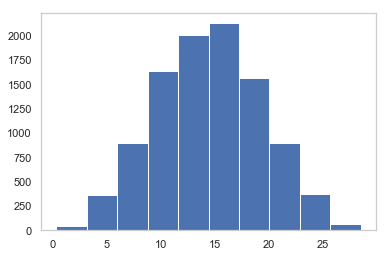

In [6]:
# distribution of target variable
h = plt.hist(y)

In [7]:
# train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
# test set for generalization of scores
X_test, y_test = make_friedman1(n_samples=5000, n_features=7, noise=0.0, random_state=21)

In [9]:
### Plotting helper functions

def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for testation set for given model 
    """
    ax = sns.distplot(y_test - model.predict(X_test), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Kernel density of residuals', size=15)

def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from testation set
    """
    ax = sns.scatterplot(x=model.predict(X_test), y = y_test)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)    

### Random Forest

In [10]:
# basic random forest regressor with mse as criterion to measure the quality of split

rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=33)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=33, verbose=0, warm_start=False)

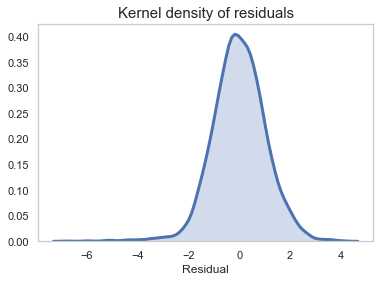

In [11]:
# distribution of residual
plot_residual_distribution(rf)

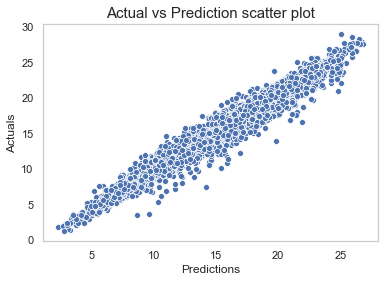

In [12]:
plot_scatter_pred_actual(rf)

In [13]:
print(f"MSE is {mean_squared_error(y_test, rf.predict(X_test))}")

MSE is 1.0918979274016403


### Default LightGBM

#### LightGBM default: MSE


In [14]:
# make new model on new value
gbm = lightgbm.LGBMRegressor(random_state=33)
gbm.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=33,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

We see that GBM has performed a better than random forest model for our validation MSE score

#### LightGBM default: MSE + early stopping


In [15]:
# make new model on new value
# 'regression' is actually also the default objective for LGBMRegressor

gbm2 = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm2.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',  # also the default
    verbose=False,
)

/Users/groverpr/.pyenv/versions/3.7.0/envs/cortex_3_7/lib/python3.7/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping_rounds=10, learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=33, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

It is basically similar to the default model we fitted in the previous section but we did not use `eval_set` in that section. Because we are specifically mentioning `eval_set` in this case, we can leverage `early_stopping_rounds` and run for more boosting iterations which improves our model performance aand saves best score based on the give `metrics and eval_score`. 

We see an improvement in score as the model is able to run for more boosting iterations 

### Assymetric Custom Loss 

There are 2 parameters that we might be interested in which define the traininig process in gradient boosted based tree based models. In context of LightGBM, we 

In LightGBM training API: 
* fobj: Customized objective function
* feval: Customized evaluation function. basically a way to use custom metric for cv. used in addition to metric 
* metric: a function to be monitored while doing cross validation. (select hyperparameters that minimize or maximuze this). can be plural

In sklearn wrapper around LightGBM API:
* objective: default parameter in model()
* eval_metric in model.fit()

I am going to use sklearn wrapper to set the objective and evaluation metric, but these are essentially the same

Let's say that we don't want our model to overpredict, but we are fine with underpredictions.    

We can make a custom loss which gives 10 times more penalty when the true targets
are less than predictions as compared to when true targets are more

In [16]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

#### Exploring our custom loss function with some plots

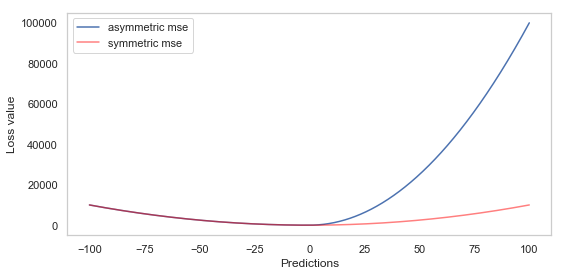

In [17]:
# let's see how our custom loss function looks with respect to different prediction values

y_true = np.repeat(0,1000)
y_pred = np.linspace(-100,100,1000)
residual = (y_true - y_pred).astype("float")

custom_loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.lineplot(y_pred, custom_loss, alpha=1, label="asymmetric mse")
sns.lineplot(y_pred, residual**2, alpha = 0.5, label = "symmetric mse", color="red")
ax.set_xlabel("Predictions")
ax.set_ylabel("Loss value")

fig.tight_layout()

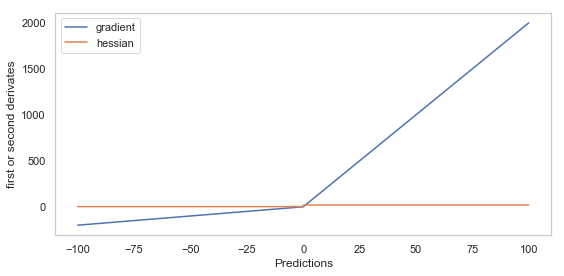

In [18]:
grad, hess = custom_asymmetric_objective(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

# ax.plot(y_hat, errors)
ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

The behaviour of gradient of custom loss is as per our expecation. The slope has a little higher value when the residual is negative as compared to when it is positive

#### LightGBM custom objective 

In [19]:
# make new model on new value
gbm3 = lightgbm.LGBMRegressor(random_state=33)
gbm3.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm3.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',
    verbose=False,
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metrics=['mse', 'mae'],
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31,
       objective=<function custom_asymmetric_objective at 0x10d92e158>,
       random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### LightGBM_early_boosting custom eval_metric


In [20]:
# make new model on new value
gbm4 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm4.set_params(**{'objective': "regression"}, metrics = ["mse", 'mae'])

gbm4.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

/Users/groverpr/.pyenv/versions/3.7.0/envs/cortex_3_7/lib/python3.7/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping_rounds=10, learning_rate=0.1, max_depth=-1,
       metrics=['mse', 'mae'], min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=33,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

#### LightGBM_early_boosting custom objective

In [21]:
# make new model on new value
gbm5 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm5.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm5.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="l2",
    verbose=False,
)

/Users/groverpr/.pyenv/versions/3.7.0/envs/cortex_3_7/lib/python3.7/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping_rounds=10, learning_rate=0.1, max_depth=-1,
       metrics=['mse', 'mae'], min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31,
       objective=<function custom_asymmetric_objective at 0x10d92e158>,
       random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### LightGBM_early_boosting custom eval_metric + objective

In [22]:
# make new model on new value
gbm6 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm6.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm6.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

/Users/groverpr/.pyenv/versions/3.7.0/envs/cortex_3_7/lib/python3.7/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping_rounds=10, learning_rate=0.1, max_depth=-1,
       metrics=['mse', 'mae'], min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31,
       objective=<function custom_asymmetric_objective at 0x10d92e158>,
       random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Reporting scores for different models

#### Scores table

In [23]:
# asymmetric mse scores
_,loss_rf,_ = custom_asymmetric_eval(y_test, rf.predict(X_test))
_,loss_gbm,_ = custom_asymmetric_eval(y_test, gbm.predict(X_test))
_,loss_gbm2,_ = custom_asymmetric_eval(y_test, gbm2.predict(X_test))
_,loss_gbm3,_ = custom_asymmetric_eval(y_test, gbm3.predict(X_test))
_,loss_gbm4,_ = custom_asymmetric_eval(y_test, gbm4.predict(X_test))
_,loss_gbm5,_ = custom_asymmetric_eval(y_test, gbm5.predict(X_test))
_,loss_gbm6,_ = custom_asymmetric_eval(y_test, gbm6.predict(X_test))

In [31]:
score_dict = {'Random Forest default':
              {'asymmetric custom mse': loss_rf,
               'symmetric mse': mean_squared_error(y_test, rf.predict(X_test)),
#                'symmetric mae': mean_absolute_error(y_test, rf.predict(X_test)), 
               '# boosting rounds' : '-'},
              
              'LightGBM default' : 
              {'asymmetric custom mse': loss_gbm,
               'symmetric mse': mean_squared_error(y_test, gbm.predict(X_test)), 
#                'symmetric mae': mean_absolute_error(y_test, gbm.predict(X_test)), 
               '# boosting rounds' : gbm.booster_.current_iteration()},
              
              'LightGBM with custom training loss (no hyperparameter tuning)': 
              {'asymmetric custom mse': loss_gbm3,
               'symmetric mse': mean_squared_error(y_test, gbm3.predict(X_test)),
#                'symmetric mae': mean_absolute_error(y_test, gbm3.predict(X_test)),
               '# boosting rounds' : gbm3.booster_.current_iteration()},
              
              'LightGBM with early stopping' : 
              {'asymmetric custom mse': loss_gbm2,
               'symmetric mse': mean_squared_error(y_test, gbm2.predict(X_test)),
#                'symmetric mae': mean_absolute_error(y_test, gbm2.predict(X_test)),
               '# boosting rounds' : gbm2.booster_.current_iteration()},

             'LightGBM with early_stopping and custom validation loss': 
              {'asymmetric custom mse': loss_gbm4,
               'symmetric mse': mean_squared_error(y_test, gbm4.predict(X_test)),
#                'symmetric mae': mean_absolute_error(y_test, gbm4.predict(X_test)),
               '# boosting rounds' : gbm4.booster_.current_iteration()},
              
              'LightGBM with early_stopping and custom training loss': 
              {'asymmetric custom mse': loss_gbm5,
               'symmetric mse': mean_squared_error(y_test, gbm5.predict(X_test)),
#                'symmetric mae': mean_absolute_error(y_test, gbm5.predict(X_test)),
               '# boosting rounds' : gbm5.booster_.current_iteration()}, 
              
              'LightGBM with early_stopping, custom training and custom validation loss': 
              {'asymmetric custom mse': loss_gbm6,
               'symmetric mse': mean_squared_error(y_test, gbm6.predict(X_test)),
#                'symmetric mae': mean_absolute_error(y_test, gbm6.predict(X_test)),
               '# boosting rounds' : gbm6.booster_.current_iteration()}
             
             }

In [32]:
pd.DataFrame(score_dict).T

,# boosting rounds,asymmetric custom mse,symmetric mse
Random Forest default,-,6.16678,1.0919
LightGBM default,100,1.31852,0.236246
LightGBM with custom training loss (no hyperparameter tuning),100,0.819872,0.330155
LightGBM with early stopping,780,0.783725,0.137639
LightGBM with early_stopping and custom validation loss,742,0.78697,0.138275
LightGBM with early_stopping and custom training loss,1848,0.868132,0.162248
"LightGBM with early_stopping, custom training and custom validation loss",241,0.740384,0.22839


#### Plots

Density plot to show comparison of LightGBM with symmetric and with asymmetric MSE functions

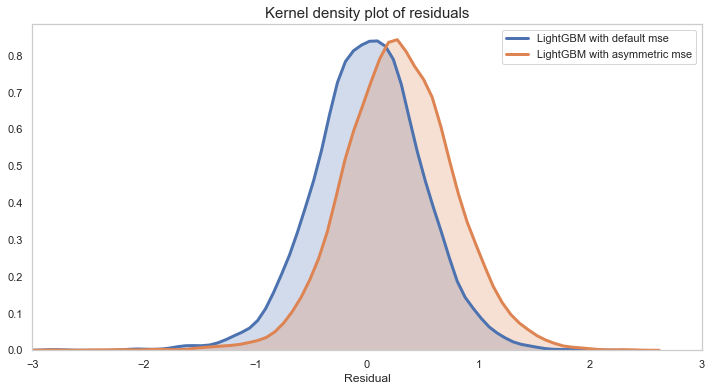

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(y_test - gbm.predict(X_test), hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual", label = "LightGBM with default mse")
ax = sns.distplot(y_test - gbm3.predict(X_test), hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual", label = "LightGBM with asymmetric mse")

# control x and y limits
ax.set_xlim(-3, 3)

title = ax.set_title('Kernel density plot of residuals', size=15)

Scatter plots

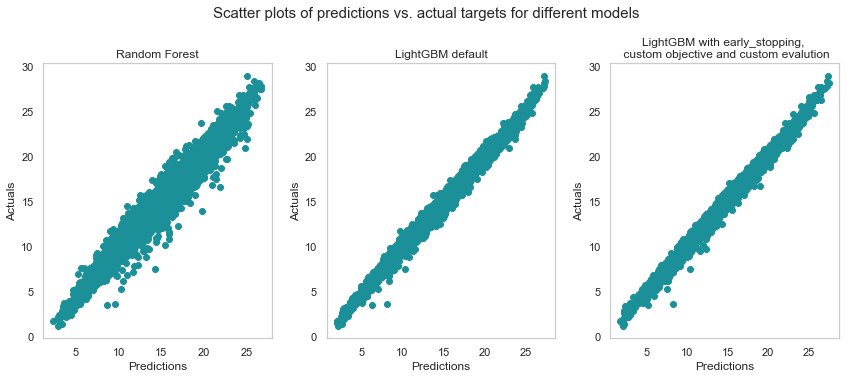

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax1, ax2, ax3 = ax.flatten()

ax1.plot(rf.predict(X_test), y_test, 'o', color='#1c9099')
ax1.set_xlabel('Predictions')
ax1.set_ylabel('Actuals')
ax1.set_title('Random Forest')  

ax2.plot(gbm.predict(X_test), y_test, 'o', color='#1c9099')
ax2.set_xlabel('Predictions')
ax2.set_ylabel('Actuals')
ax2.set_title('LightGBM default') 

ax3.plot(gbm6.predict(X_test), y_test, 'o', color='#1c9099')
ax3.set_xlabel('Predictions')
ax3.set_ylabel('Actuals')
ax3.set_title('LightGBM with early_stopping, \n custom objective and custom evalution') 

fig.suptitle("Scatter plots of predictions vs. actual targets for different models", y = 1.05, fontsize=15)
fig.tight_layout()

Error histograms

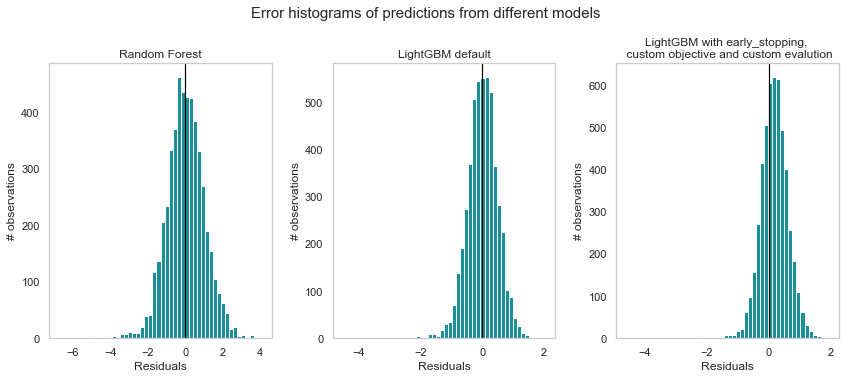

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax1, ax2, ax3 = ax.flatten()

ax1.hist(y_test - rf.predict(X_test), bins=50, color='#1c9099')
ax1.axvline(x=0, ymin=0, ymax=500, color='black', lw=1.2)
ax1.set_xlabel('Residuals')
ax1.set_title('Random Forest')  
ax1.set_ylabel('# observations')

ax2.hist(y_test - gbm.predict(X_test), bins=50,  color='#1c9099')
ax2.axvline(x=0, ymin=0, ymax=500, color='black', lw=1.2)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('# observations')
ax2.set_title('LightGBM default') 

ax3.hist(y_test - gbm6.predict(X_test), bins=50,  color='#1c9099')
ax3.axvline(x=0, ymin=0, ymax=500, color='black', lw=1.2)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('# observations')
ax3.set_title('LightGBM with early_stopping, \n custom objective and custom evalution') 

fig.suptitle("Error histograms of predictions from different models", y = 1.05, fontsize=15)
fig.tight_layout()

### End